In [67]:
# Import modules
import numpy as np

# Import functions
from local_global_matrices import *
from assembly_K_matrices import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
# Import data
d_dat = np.genfromtxt('data/d.dat')
fP_dat = np.genfromtxt('data/fP.dat')
fr_dat = np.genfromtxt('data/fr.dat')
Ks = np.genfromtxt('data/localK.dat')
solution = np.genfromtxt('data/solution.dat')

In [69]:
# Initial data
# Number of subdomains
Nsub_x = 4
Nsub_y = 3

# Number of remaining nodes in each subdomain
Nr_x = 4
Nr_y = 3

# Local remaining and primal indices
rs = np.array([1, 2, 4, 5, 6, 7, 9, 10])
qs = np.array([0, 3, 8, 11])

In [70]:
# Transformation matrices A
# Primal nodes local-global transformation matrices
APq = create_APq_matrices(Nsub_x, Nsub_y)

# Remaining nodes local-global transformation matrices
ARr = create_ARr_matrices(Nsub_x, Nsub_y, Nr_x, Nr_y)

In [71]:
# Stiffness matrices K
KRR = assembly_KRR_matrix(Ks, ARr, rs)
KPP = assembly_KPP_matrix(Ks, APq, qs)
KRP = assembly_KPR_matrix(Ks, APq, ARr, qs, rs)
KPR = KRP.T

In [72]:
Nr = Nr_x*Nr_y - 4  # Number of local remaining nodes r
NR = Nr*(Nsub_x*Nsub_y)  # Number of total remaining nodes R
Nq = 4 # Number of primal nodes in each subdomain 
NP = (Nsub_x + 1)*(Nsub_y + 1) # Total number of primal nodes

In [73]:
NlambdaR = (Nsub_x*(Nr_x - 2)) * (Nsub_y - 1) + (Nsub_y*(Nr_y - 2)) * (Nsub_x - 1)
NlambdaP_Dir = 4 # hardcoded
NlambdaR_Dir = 3 # hardcoded



Nlambda = NlambdaR + NlambdaR_Dir + NlambdaP_Dir

In [74]:
d = np.zeros(Nlambda)
np.shape(d)

(32,)

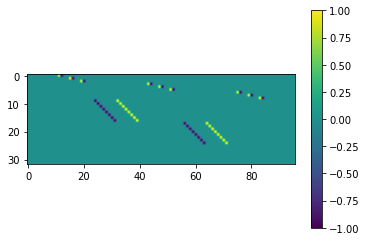

In [75]:
Nr = Nr_x*Nr_y - 4  # Number of local remaining nodes r
NR = Nr*(Nsub_x*Nsub_y)  # Number of total remaining nodes R
BlambdaR = np.zeros([Nlambda, NR])

for j in range(Nsub_y):
    for i in range(Nsub_x):
        Brs = np.zeros([Nlambda, Nr])
        # Local rs nodes in boundaries
        rs_bot = np.arange(Nr_x - 2)
        rs_top = np.arange(Nr_x - 2) + (Nr_y - 2)*Nr_x + (Nr_x - 2)
        rs_left = np.arange(Nr_x - 2, (Nr_y - 2)*(Nr_x) + Nr_x - 2, Nr_x)
        rs_right = rs_left + Nr_x - 1

        Nrs_hor = Nr_x - 2
        Nrs_ver = Nr_y - 2

        # left
        if i > 0:
            lambda_left = np.arange((i-1) + j*(Nr_y - 2)*(Nsub_x - 1), Nrs_ver*(Nsub_x - 1) + (i-1) + j*(Nr_y - 2)*(Nsub_x - 1),step=Nsub_x - 1)
            # print('left', lambda_left)
            for lambda_, rs in zip(lambda_left, rs_left):
                Brs[int(lambda_), int(rs)] = -1
        # right
        if i < Nsub_x - 1:
            lambda_right = np.arange((i) + j*(Nr_y - 2)*(Nsub_x - 1), Nrs_ver*(Nsub_x - 1) + (i) + j*(Nr_y - 2)*(Nsub_x - 1),step=Nsub_x - 1)
            # print('right', lambda_right)
            for lambda_, rs in zip(lambda_right, rs_right):
                Brs[int(lambda_), int(rs)] = 1
        # bottom
        NlambdaR_hor = (Nr_y - 2)*(Nsub_y)*(Nsub_x - 1)
        if j > 0:
            lambda_bot = np.arange(NlambdaR_hor + (j - 1)*(Nr_x - 2)*Nsub_x + i*(Nr_x - 2), NlambdaR_hor + (j - 1)*(Nr_x - 2)*Nsub_x + i*(Nr_x - 2) + (Nr_x - 2))
            # print('bot', lambda_bot)
            for lambda_, rs in zip(lambda_bot, rs_bot):
                Brs[int(lambda_), int(rs)] = 1
        # top
        if j < Nsub_y - 1:
            lambda_top = np.arange(NlambdaR_hor + (j)*(Nr_x - 2)*Nsub_x + i*(Nr_x - 2), NlambdaR_hor + (j)*(Nr_x - 2)*Nsub_x + i*(Nr_x - 2) + (Nr_x - 2))
            # print('top', lambda_top)
            for lambda_, rs in zip(lambda_top, rs_top):
                Brs[int(lambda_), int(rs)] = -1

        BlambdaR += Brs @ ARr[i + j*Nsub_x].T

plot_sparse_matrix(BlambdaR)

In [76]:
# Dirichlet boundary conditions
# Left wall remaining

Nr_x = 4
Nr_y = 3
Nsub_x = 4
Nsub_y = 3
NlambdaR = 25
BlambdaR_aux = np.zeros([Nlambda, NR])
for j in range(Nsub_y):
    Brs = np.zeros([Nlambda, Nr])
    rs_left = np.arange(Nr_x - 2, (Nr_y - 2)*(Nr_x) + Nr_x - 2, Nr_x)
    lambda_left = np.arange(NlambdaR + (Nr_y - 1)*j + 1, NlambdaR + (Nr_y - 1)*j + 1 + Nr_y - 2)
    #d_left = np.arange(1 + j*(Nr_y - 1), 1+j*(Nr_y - 1) + Nr_y - 2)
    for rs, lambda_ in zip(rs_left, lambda_left):
        Brs[lambda_, rs] = 1
    BlambdaR_aux += Brs @ ARr[j*Nsub_x].T
    
BlambdaR += BlambdaR_aux    



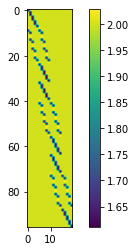

In [77]:
#Left wall primal
BlambdaP = np.zeros([Nlambda, NP])

for j in range(Nsub_y):
    Bqs = np.zeros([Nlambda, Nq])
    if j == 0:
        Bqs[NlambdaR, 0] = 1
    Bqs[NlambdaR + j*(Nr_y - 1) + Nr_y - 1, 2] = 1
    BlambdaP += Bqs @ APq[j*Nsub_x].T
    
plot_sparse_matrix(KRP)

In [78]:
# Assembly d
d[NlambdaR:]=d_dat

In [79]:
# Assembly f
# fP
fP = fP_dat

# fR
fR = np.zeros(NR)

In [80]:
NR

96

In [81]:
for j in range(Nsub_y):
    for i in range(Nsub_x):
        Rs = []
        for sj in range(Nr_y):
            if sj == 0:
                Rs = np.concatenate([Rs, np.arange(j*(Nsub_x*Nr) + i*(Nr_x - 2), j*(Nsub_x*Nr) + i*(Nr_x - 2) + Nr_x - 2)])
            elif sj == Nr_y - 1:
                Rs = np.concatenate([Rs, np.arange(j*(Nsub_x*Nr) + i*(Nr_x - 2) + Nsub_x*Nr_x*(Nr_y - 2) + Nsub_x*(Nr_x - 2),
                                                   j*(Nsub_x*Nr) + i*(Nr_x - 2) + Nsub_x*Nr_x*(Nr_y - 2) + Nsub_x*(Nr_x - 2) + Nr_x - 2)])
            else:
                Rs = np.concatenate([Rs, np.arange(j*(Nsub_x*Nr) + i*(Nr_x) + Nsub_x*Nr_x*(sj - 1) + Nsub_x*(Nr_x - 2), 
                                                   j*(Nsub_x*Nr) + i*(Nr_x) + Nsub_x*Nr_x*(sj - 1) + Nsub_x*(Nr_x - 2) + Nr_x)])
        fR[Rs.astype(int)] = fr_dat



In [82]:
print(np.shape(KPP), np.shape(KPR), np.shape(np.linalg.inv(KRR)), np.shape(KRP))

(20, 20) (20, 96) (96, 96) (96, 20)


In [102]:
KRR_inv = np.linalg.inv(KRR)
SPP = KPP - KPR @ KRR_inv @ KRP
SPP_inv = np.linalg.inv(SPP)
np.shape(KRR_inv)

(96, 96)

In [92]:
fPH = fP - KPR @ KRR_inv @ fR

In [95]:
dH = -d + BlambdaP @ SPP_inv @ fPH + BlambdaR @ KRR_inv @ fR - BlambdaR @ KRR_inv @ KRP @ SPP_inv @ fPH
np.shape(dH)

(32,)

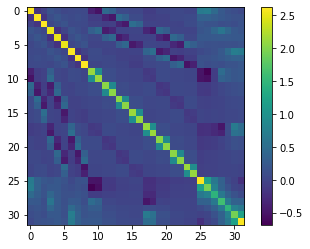

In [107]:
F = -BlambdaP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T + BlambdaP @ SPP_inv @ BlambdaP.T + BlambdaR @ KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T - BlambdaR @ KRR_inv @ KRP @ SPP_inv @ BlambdaP.T + BlambdaR @ KRR_inv @ BlambdaR.T
np.shape(F)
plot_sparse_matrix(F)

In [108]:
lambda_ = np.linalg.solve(F, dH)

In [109]:
lambda_

array([ 0.51746684,  0.43858385,  0.2843983 ,  0.69623382,  0.50088304,
        0.29629248,  0.89456307,  0.56699829,  0.32397136,  0.26080445,
        0.19594398,  0.10718585,  0.08083536,  0.04969009,  0.04155966,
        0.03631108,  0.03447199,  0.24989827,  0.18029308,  0.07904008,
        0.05021373,  0.01614394,  0.00593827, -0.00891034, -0.01139071,
       -0.22304335, -0.38304967, -0.90861267, -0.80588513, -1.2592788 ,
       -1.26370101, -1.1822901 ])

In [112]:
uP = SPP_inv @ fPH + SPP_inv @ KPR @ KRR_inv @ BlambdaR.T @ lambda_ - SPP_inv @ BlambdaP.T @ lambda_
uP

array([ 1.        ,  0.30098417, -0.62726893, -1.34390027, -1.88284308,
        2.        ,  0.67008019, -0.39555668, -1.149944  , -1.57146783,
        3.        ,  1.09135488, -0.24580204, -1.09290034, -1.53630698,
        4.        ,  1.16848728, -0.32713698, -1.2297974 , -1.8125206 ])

In [115]:
uR = KRR_inv @ (fR - KRP @ uP - BlambdaR.T @ lambda_)
uR

array([ 1.01830669e+00,  7.59736290e-01,  1.33737978e-01, -1.79567536e-01,
       -7.45354371e-01, -9.85162156e-01, -1.36505773e+00, -1.51192411e+00,
        1.50000000e+00,  1.21094215e+00,  8.92364776e-01,  5.72454985e-01,
        5.72454985e-01,  2.18446704e-01, -1.06712403e-01, -3.93699410e-01,
       -3.93699410e-01, -6.85854855e-01, -9.28830098e-01, -1.11978432e+00,
       -1.11978432e+00, -1.30703157e+00, -1.43808536e+00, -1.43622958e+00,
        1.57146638e+00,  1.14368943e+00,  3.55233373e-01, -1.58714607e-03,
       -6.17496366e-01, -8.69747778e-01, -1.25039348e+00, -1.37335595e+00,
        1.57146638e+00,  1.14368943e+00,  3.55233373e-01, -1.58714607e-03,
       -6.17496366e-01, -8.69747778e-01, -1.25039348e+00, -1.37335595e+00,
        2.50000000e+00,  1.97690306e+00,  1.45466030e+00,  9.78229273e-01,
        9.78229273e-01,  5.28602977e-01,  1.28874393e-01, -2.19908002e-01,
       -2.19908002e-01, -5.38435469e-01, -8.04734937e-01, -1.01793554e+00,
       -1.01793554e+00, -

In [126]:
class RegularSubdomainsMesh:
    def __init__(self, Nsub_x, Nsub_y, Nr_x, Nr_y):
        self.Nsub_x = Nsub_x
        self.Nsub_y = Nsub_y
        self.Nr_x = Nr_x
        self.Nr_y = Nr_y

        # Number of primal nodes
        self.Nq = 4 # local
        self.NP = (Nsub_x + 1) * (Nsub_y + 1) # global
        
        # Number of remaining nodes
        self.Nr = Nr_x*Nr_y - 4 # local
        self.NR = self.Nr * (Nsub_x*Nsub_y) # global
                
    
   

mesh = RegularSubdomainsMesh(4, 3, 4, 3)



4